# Introduction to SQuAD 2.0 and Question Answering

The Stanford Question Answering Dataset (SQuAD) is a popular dataset used in the field of Natural Language Processing (NLP). This dataset is designed for the task of Machine Reading Comprehension (MRC), which involves a machine's ability to read, understand, and answer questions about a given context. The second iteration, SQuAD 2.0, adds a layer of complexity by including questions that are unanswerable based on the provided context, thereby challenging the model not only to find the correct answer but also to determine when no appropriate answer is available.

The dataset comprises over 100,000 real questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage. Around 50,000 of these questions are unanswerable.

Unlike SQuAD 2.0, most of the previous datasets in this area were generated primarily for answering questions that were from the comprehension as mentioned above or were used to automatically generate unanswerable questions, which were easy for models, in general, to identify and perform well. This could be attributed to the fact that a recent analysis shows that success on the SQuAD dataset doesn’t ensure robustness to distracting sentences and that the models do well only by learning the context and type matching heuristics [1]. One major reason for this is that SQuAD 1.0 works on questions for which there exists a definitive answer. This actually makes the model to only search for areas of the text most related to the question and not the answer in itself. It simply searched for patterns across the text, finds the one it sees similar (Doc2Vec if you can think about it that way) and matches it.

Example of a context (left), a question (right) and the answers (ground truth and model prediction):
![Picture title](image-20230527-190716.png)

The primary task with this dataset is to create a model that can: 

1. Accurately answer the provided questions or 

undefined. Assert that the question is unanswerable given the available information. 

This is a significant challenge in the field of NLP and is a step towards creating more sophisticated AI that can understand and interact with text in a nuanced manner.

Historically, question answering systems were trained to locate the answer in the text, or to produce only a limited set of possible answers by categorizing the question into classes corresponding to the most frequent answers to questions. More recently, however, Question Answering (QA) systems have been developed to generate the response text, opening up a broader range of possible answers.

In this notebook, we will embark on an exploratory data analysis journey into the SQuAD 2.0 dataset. We will investigate the structure and characteristics of the data. Our ultimate goal is to gain a deeper understanding of the data and the task, and to identify a model that performs well on this challenging problem. 

In [1]:
!pip3 install wordcloud 

In [2]:
import json
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import string
import re
import seaborn as sns
import pandas as pd
import collections
import numpy as np
import collections
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk import FreqDist

regex_punctuation = '[' + string.punctuation + ']'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading & Parsing SQUAD 2.0

This block of code is loading and parsing the SQuAD 2.0 training dataset, which is the first step in any data analysis process. Having the data loaded into a Python dictionary will allow you to interact with it in a more convenient and efficient way.

In [3]:
data_name = "train-v2.0.json"
data = open(data_name, "r")
data_json = json.loads(data.read())

dataset = data_json["data"]

# Data Preprocessing & Feature Extraction

This block of code is essentially performing data preprocessing and feature extraction to prepare for data visualization and exploration. The purpose of this code is to extract meaningful statistics and features from the raw SQuAD 2.0 data, which can then be used for further analysis and visualization.

The code is creating a number of lists, each of which will hold a particular type of information about the dataset. The code then iterates through the dataset. For each article, it calculates and records the desired information, such as the number of paragraphs, questions, answerable and unanswerable questions, and the number of words in paragraphs, questions, and answers.

This extraction is crucial for the exploration and visualization phase because it transforms the raw data into a form that can be easily analyzed. These statistics provide insights about the dataset's structure and can help us understand patterns and trends in the data, such as the typical length of questions or the proportion of questions that are unanswerable. Such understanding is fundamental for choosing the right modelling approach and for interpreting the model's performance later on.

In [4]:
number_of_paragraphs_per_article = []
number_of_questions_per_paragraph = []
number_of_questions_per_article = []
number_of_unanswerable_questions_per_article = []
number_of_unanswerable_questions_per_paragraph = []
number_of_answerable_questions_per_article = []
number_of_answerable_questions_per_paragraph = []
number_of_words_per_paragraph = []
number_of_words_per_paragraph_nopunctuation_nostopwords = []
number_of_words_per_question = []
number_of_words_per_question_nopunctuation_nostopwords = []
number_of_words_per_answer = []
number_of_words_per_answer_nopunctuation_nostopwords = []
number_of_unanswerable_questions = 0

for topic in dataset:
    number_of_paragraphs_per_article.append(len(topic["paragraphs"]))
    for paragraph in topic["paragraphs"]:
        number_of_questions_per_paragraph.append(len(paragraph['qas']))
        number_of_answerable_questions_per_paragraph.append(0)
        number_of_unanswerable_questions_per_paragraph.append(0)
        paragraph_text = paragraph['context']
        paragraph_text_nopunctuation = re.sub(regex_punctuation,'',paragraph_text).split()
        paragraph_text_nopunctuation_nostopwords = [w for w in paragraph_text_nopunctuation if w not in stopwords.words('english')]
        number_of_words_per_paragraph.append(len(paragraph_text.split()))
        number_of_words_per_paragraph_nopunctuation_nostopwords.append(len(paragraph_text_nopunctuation_nostopwords))
        for qas in paragraph["qas"]:
            if int(qas['is_impossible']) == 1:
                number_of_unanswerable_questions_per_paragraph[-1] += 1
                number_of_unanswerable_questions += 1
            else:
                number_of_answerable_questions_per_paragraph[-1] += 1
            question_text = qas["question"]
            question_text_nopunctuation = re.sub(regex_punctuation,'',question_text).split()
            question_nopunctuation_nostopwords = [w for w in question_text_nopunctuation if w not in stopwords.words('english')]
            number_of_words_per_question.append(len(question_text.split()))
            number_of_words_per_question_nopunctuation_nostopwords.append(len(question_nopunctuation_nostopwords))
            for a in qas["answers"]:
                answer_text = a["text"]
                answer_text_nopunctuation = re.sub(regex_punctuation,'',answer_text).split()
                answer_text_nopunctuation_nostopwords = [w for w in answer_text_nopunctuation if w not in stopwords.words('english')]
                number_of_words_per_answer.append(len(answer_text.split()))
                number_of_words_per_answer_nopunctuation_nostopwords.append(len(answer_text_nopunctuation_nostopwords))
    number_of_questions_per_article.append(sum(number_of_questions_per_paragraph)-sum(number_of_questions_per_article))
    number_of_answerable_questions_per_article.append(sum(number_of_answerable_questions_per_paragraph)-sum(number_of_answerable_questions_per_article))
    number_of_unanswerable_questions_per_article.append(sum(number_of_unanswerable_questions_per_paragraph)-sum(number_of_unanswerable_questions_per_article))

## Number of Paragraphs per Article

This code segment is focused on understanding the distribution of the number of paragraphs across different articles in the SQuAD 2.0 dataset.

First, it prints out a set of statistics. These metrics provide a quick overview of the dataset's structure at the article and paragraph level.

Then, it generates a histogram to visualize the distribution of the number of paragraphs per article. The histogram uses a Kernel Density Estimate (KDE) to provide a smooth curve that approximates the distribution.

Visualizing this distribution is an essential step in data exploration because it helps you understand the variability in the length of the articles in terms of the number of paragraphs. This insight can be valuable when considering how to handle articles of varying lengths in your model. For example, if there is a lot of variability, you might need to consider techniques for handling long articles or balancing your training data.

Number of total articles:  442
Number of total paragraphs:  19035
Maximum number of paragraphs per article:  149
Minimum number of paragraphs per article:  10
Average number of paragraphs per article:  43.06561085972851


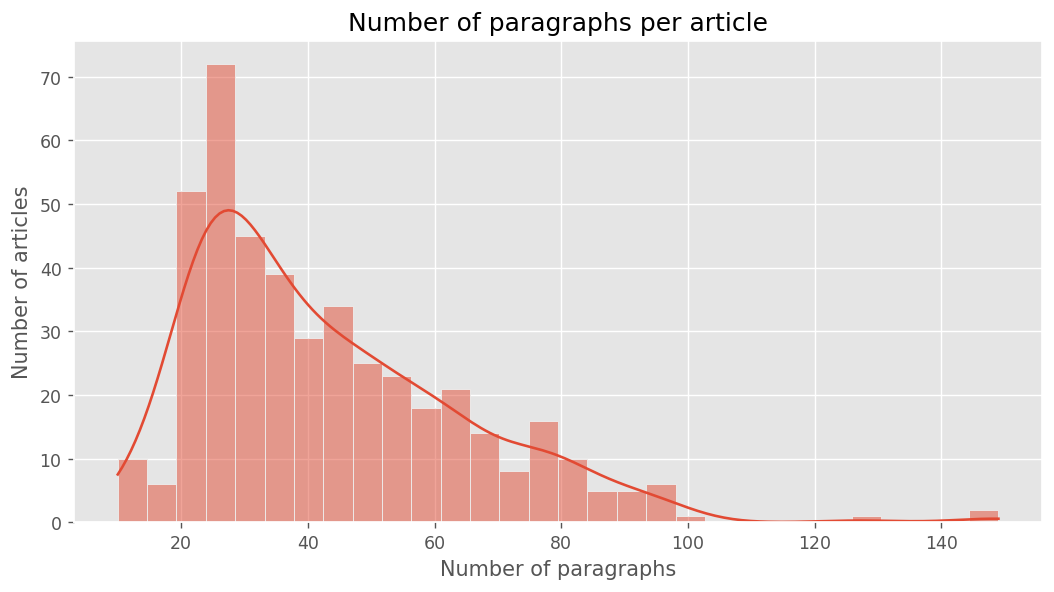

In [5]:
#all_paragraphs_per_article = [article['paragraphs'] for article in dataset]
#number_of_paragraphs_per_article = [len(paragraphs_per_article) for paragraphs_per_article in all_paragraphs_per_article]

print("Number of total articles: ", len(dataset))
print("Number of total paragraphs: ", sum(number_of_paragraphs_per_article))
print("Maximum number of paragraphs per article: ", max(number_of_paragraphs_per_article))
print("Minimum number of paragraphs per article: ", min(number_of_paragraphs_per_article))
print("Average number of paragraphs per article: ", sum(number_of_paragraphs_per_article)/len(dataset))

num_bin = 30
intervallo_bin = (max(number_of_paragraphs_per_article) - min(number_of_paragraphs_per_article)) / num_bin

plt.figure(figsize=(10, 5), dpi=125)
sns.histplot(number_of_paragraphs_per_article, bins=num_bin, kde=True)
plt.xlabel('Number of paragraphs')
plt.ylabel('Number of articles')
plt.title('Number of paragraphs per article')
plt.show()

## Question Statistics

This code segment is dedicated to analyzing and understanding the distribution of questions, both answerable and unanswerable, across paragraphs and articles in the SQuAD 2.0 dataset.

### Class Imbalance

With the introduction of 50,000 no answer questions to the SQuAD dataset with SQuAD 2.0, the dataset, now suffers from an imbalance between answerable and unanswerable questions [2]. Data augmentation has been shown to be a viable method of balancing a dataset by generating more examples based on the ones provided and also has been shown to be an effective technique to improve the performance of models on many Natural Language Processing tasks [3].

In [6]:
# Plot sum(number_of_unanswerable_questions) and  sum(number_of_answerable_questions_per_paragraph) as a pie chart
plt.figure(figsize=(10, 5), dpi=125)
plt.pie([sum(number_of_unanswerable_questions_per_paragraph), sum(number_of_answerable_questions_per_paragraph)], labels=['Unanswerable questions', 'Answerable questions'], autopct='%1.1f%%')
plt.title('Answerable and Unanswerable Questions')
plt.show()

The following metrics give a high-level overview of the distribution of questions within the dataset and highlight the proportion of questions that are unanswerable. Understanding this distribution is critical for data visualization and exploration as it provides insights into the complexity and challenges of the task at hand. For instance, if a significant portion of questions are unanswerable, this indicates the need for a model that can effectively determine when a question cannot be answered based on the provided context.

Further, it could reveal interesting patterns in the data that could influence your approach to model training and evaluation. For example, if articles or paragraphs with a high number of unanswerable questions are found, it could suggest a greater degree of difficulty or complexity in those sections, which might require special attention.

In [7]:
#all_questions_per_paragraph = []
#number_of_questions_per_paragraph = []
#number_of_questions_per_article = []
#number_of_unanswerable_questions_per_article = []
#number_of_unanswerable_questions_per_paragraph = []
#number_of_answerable_questions_per_article = []
#number_of_answerable_questions_per_paragraph = []
#for paragraphs in all_paragraphs_per_article:
#    for paragraph in paragraphs:
#        all_questions_per_paragraph.append(paragraph['qas'])
#        number_of_questions_per_paragraph.append(len(paragraph['qas']))
#        number_of_answerable_questions_per_paragraph.append(0)
#        number_of_unanswerable_questions_per_paragraph.append(0)
#        for question in paragraph['qas']:
#            if int(question['is_impossible']) == 1:
#                number_of_unanswerable_questions_per_paragraph[-1] += 1
#            else:
#                number_of_answerable_questions_per_paragraph[-1] += 1
#    number_of_questions_per_article.append(sum(number_of_questions_per_paragraph)-sum(number_of_questions_per_article))
#    number_of_answerable_questions_per_article.append(sum(number_of_answerable_questions_per_paragraph)-sum(number_of_answerable_questions_per_article))
#    number_of_unanswerable_questions_per_article.append(sum(number_of_unanswerable_questions_per_paragraph)-sum(number_of_unanswerable_questions_per_article))

print("Number of total questions: ", sum(number_of_questions_per_paragraph))
print("\n")

print("Number of total unanswerable questions: ", number_of_unanswerable_questions)
print("\n")

print("Maximum number of questions per paragraph: ", max(number_of_questions_per_paragraph))
print("Minimum number of questions per paragraph: ", min(number_of_questions_per_paragraph))
print("Average number of questions per paragraph: ", sum(number_of_questions_per_paragraph)/sum(number_of_paragraphs_per_article))
print("\n")

print("Maximum number of questions per article: ", max(number_of_questions_per_article))
print("Minimum number of questions per article: ", min(number_of_questions_per_article))
print("Average number of questions per article: ", sum(number_of_questions_per_article)/len(dataset))
print("\n")

print("Maximum number of answerable questions per paragraph: ", max(number_of_answerable_questions_per_paragraph))
print("Minimum number of answerable questions per paragraph: ", min(number_of_answerable_questions_per_paragraph))
print("Average number of answerable questions per paragraph: ", sum(number_of_answerable_questions_per_paragraph)/sum(number_of_paragraphs_per_article))
print("\n")

print("Maximum number of unanswerable questions per paragraph: ", max(number_of_unanswerable_questions_per_paragraph))
print("Minimum number of unanswerable questions per paragraph: ", min(number_of_unanswerable_questions_per_paragraph))
print("Average number of unanswerable questions per paragraph: ", sum(number_of_unanswerable_questions_per_paragraph)/sum(number_of_paragraphs_per_article))
print("\n")

print("Maximum number of answerable questions per article: ", max(number_of_answerable_questions_per_article))
print("Minimum number of answerable questions per article: ", min(number_of_answerable_questions_per_article))
print("Average number of answerable questions per article: ", sum(number_of_answerable_questions_per_article)/len(dataset))
print("\n")

print("Maximum number of unanswerable questions per article: ", max(number_of_unanswerable_questions_per_article))
print("Minimum number of unanswerable questions per article: ", min(number_of_unanswerable_questions_per_article))
print("Average number of unanswerable questions per article: ", sum(number_of_unanswerable_questions_per_article)/len(dataset))


Number of total questions:  130319


Number of total unanswerable questions:  43498


Maximum number of questions per paragraph:  30
Minimum number of questions per paragraph:  1
Average number of questions per paragraph:  6.84628316259522


Maximum number of questions per article:  883
Minimum number of questions per article:  36
Average number of questions per article:  294.8393665158371


Maximum number of answerable questions per paragraph:  25
Minimum number of answerable questions per paragraph:  0
Average number of answerable questions per paragraph:  4.561124244812188


Maximum number of unanswerable questions per paragraph:  15
Minimum number of unanswerable questions per paragraph:  0
Average number of unanswerable questions per paragraph:  2.2851589177830314


Maximum number of answerable questions per article:  817
Minimum number of answerable questions per article:  0
Average number of answerable questions per article:  196.42760180995475


Maximum number of unanswerable q

### Number of questions per paragraph

This code segment is generating a histogram to visualize the distribution of the number of questions across different paragraphs in the SQuAD 2.0 dataset.

The histogram uses a Kernel Density Estimate (KDE) to provide a smooth curve that approximates the probability density function of the distribution. 

This kind of visualization is important in data exploration as it provides a clear view of how the number of questions is spread across different paragraphs. This can help you understand whether most paragraphs have a similar number of questions or whether there are significant variations. Such insights can help guide subsequent data preprocessing steps and model selection. For instance, if there are paragraphs with a significantly higher number of questions, you might need to consider whether your model can handle such cases.

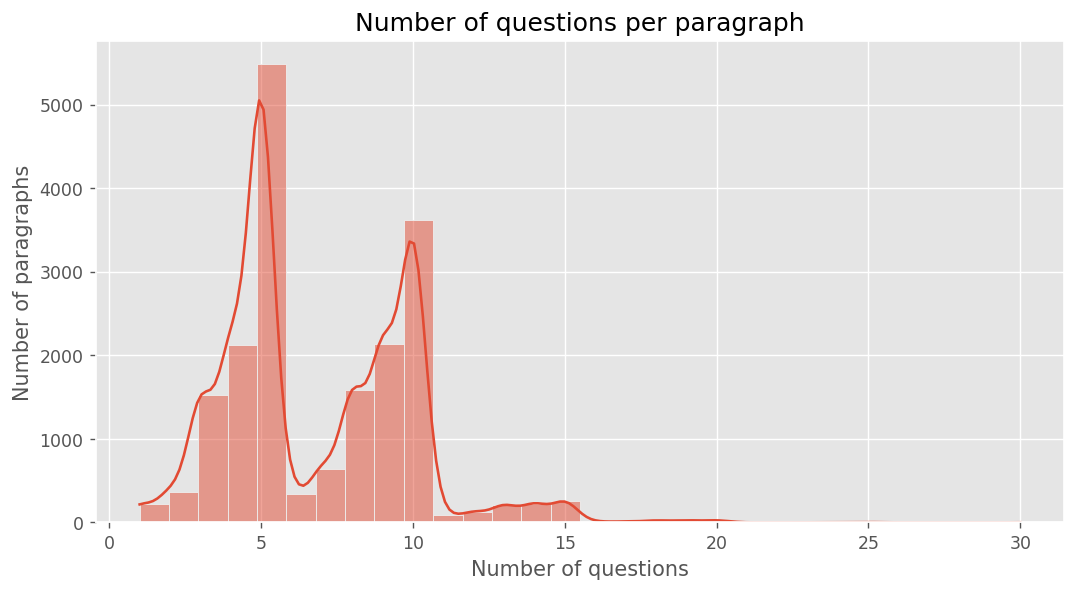

In [8]:
num_bin = 15
intervallo_bin = (max(number_of_questions_per_paragraph) - min(number_of_questions_per_paragraph)) / num_bin

plt.figure(figsize=(10, 5), dpi=125)
sns.histplot(number_of_questions_per_paragraph, bins=num_bin*2, kde=True)
plt.xlabel('Number of questions')
plt.ylabel('Number of paragraphs')
plt.title('Number of questions per paragraph')
plt.show()

This code segment is creating two overlaid histograms to visualize the distribution of the number of answerable and unanswerable questions across different paragraphs in the SQuAD 2.0 dataset.

This visualization is important for understanding the balance between answerable and unanswerable questions in the dataset. It can help reveal if there's an imbalance between these two categories and how they are distributed across paragraphs. Understanding this distribution is crucial for model training and evaluation because it can influence the model's ability to learn from both types of questions. If there's a significant imbalance, you might need to consider strategies to address this, such as oversampling the minority class or using evaluation metrics that are robust to class imbalance.

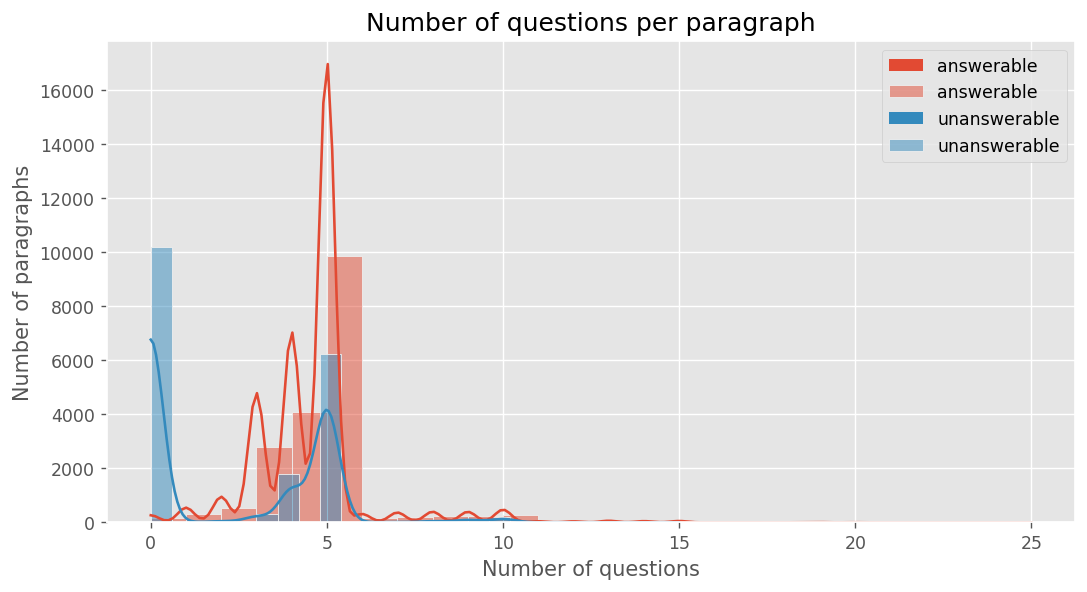

In [9]:
num_bin = 25
intervallo_bin = (max(number_of_answerable_questions_per_paragraph) - min(number_of_answerable_questions_per_paragraph)) / num_bin

plt.figure(figsize=(10, 5), dpi=125)
sns.histplot(number_of_answerable_questions_per_paragraph, bins=num_bin*1, kde=True, label='answerable')
sns.histplot(number_of_unanswerable_questions_per_paragraph, bins=num_bin*1, kde=True, label='unanswerable')
plt.xlabel('Number of questions')
plt.ylabel('Number of paragraphs')
plt.title('Number of questions per paragraph')
plt.legend(loc='upper right')
plt.show()

### Number of Questions per Article

In [10]:
num_bin = 15
intervallo_bin = (max(number_of_questions_per_article) - min(number_of_questions_per_article)) / num_bin

plt.figure(figsize=(10, 5), dpi=125)
sns.histplot(number_of_questions_per_article, bins=num_bin*2, kde=True)
plt.xlabel('Number of questions')
plt.ylabel('Number of articles')
plt.title('Number of questions per article')
plt.show()

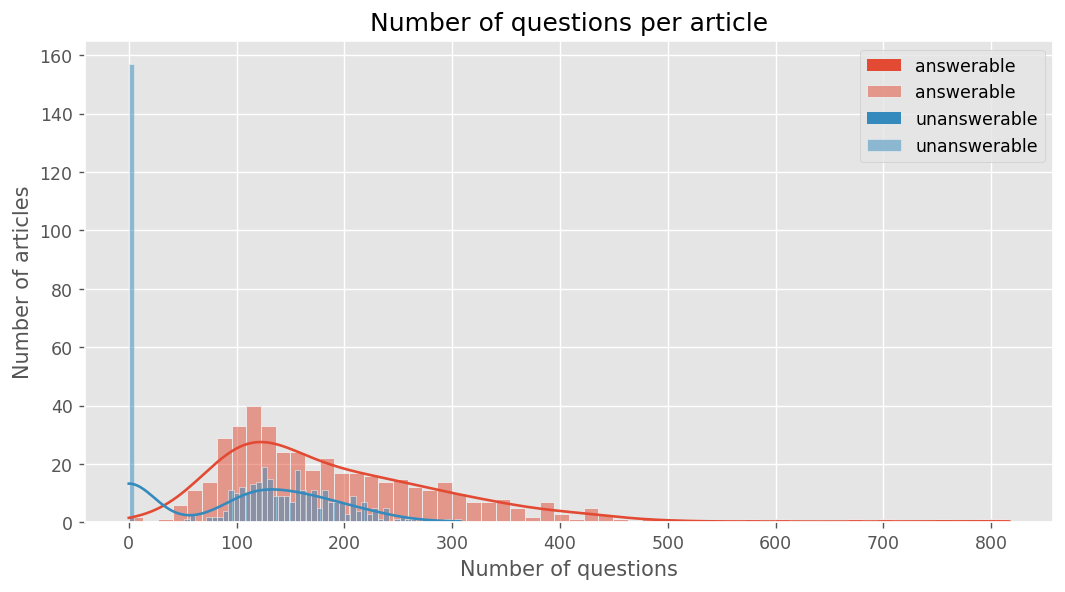

In [11]:
num_bin = 60
intervallo_bin = (max(number_of_answerable_questions_per_article) - min(number_of_answerable_questions_per_article)) / num_bin

plt.figure(figsize=(10, 5), dpi=125)
sns.histplot(number_of_answerable_questions_per_article, bins=num_bin*1, kde=True, label='answerable')
sns.histplot(number_of_unanswerable_questions_per_article, bins=num_bin*1, kde=True, label='unanswerable')
plt.xlabel('Number of questions')
plt.ylabel('Number of articles')
plt.title('Number of questions per article')
plt.legend(loc='upper right')
plt.show()

## Number of Words

### Number of Words per Paragraph

This code creates two overlaid histograms to visualize the distribution of the number of words in paragraphs of the SQuAD 2.0 dataset. It compares the distribution of the number of words in two scenarios: 

1. When punctuation and common words (stopwords) are included
2. When punctuation and stopwords are removed

By creating histograms and using Kernel Density Estimates (KDE) for these two scenarios, it allows you to visualize and compare the underlying probability density functions.

This visualization is key for understanding the general length of the text passages in the dataset, both in their raw form and when preprocessed to remove punctuation and stopwords. It provides insights on the complexity and verbosity of the dataset, which could have implications on the type of model used or the specific preprocessing steps needed. For instance, models like BERT have a maximum input length, which might require additional considerations if the paragraphs are generally long. Comparing the two scenarios also highlights the impact of preprocessing steps on the dataset, showing how much of the text is composed of punctuation and stopwords.

Maximum number of words per paragraph:  653
Minimum number of words per paragraph:  20
Average number of words per paragraph:  116.58550039401104
Maximum number of words per paragraph without punctuation and stopwords:  433
Minimum number of words per paragraph without punctuation and stopwords:  13
Average number of words per paragraph without punctuation and stopwords:  73.21481481481482


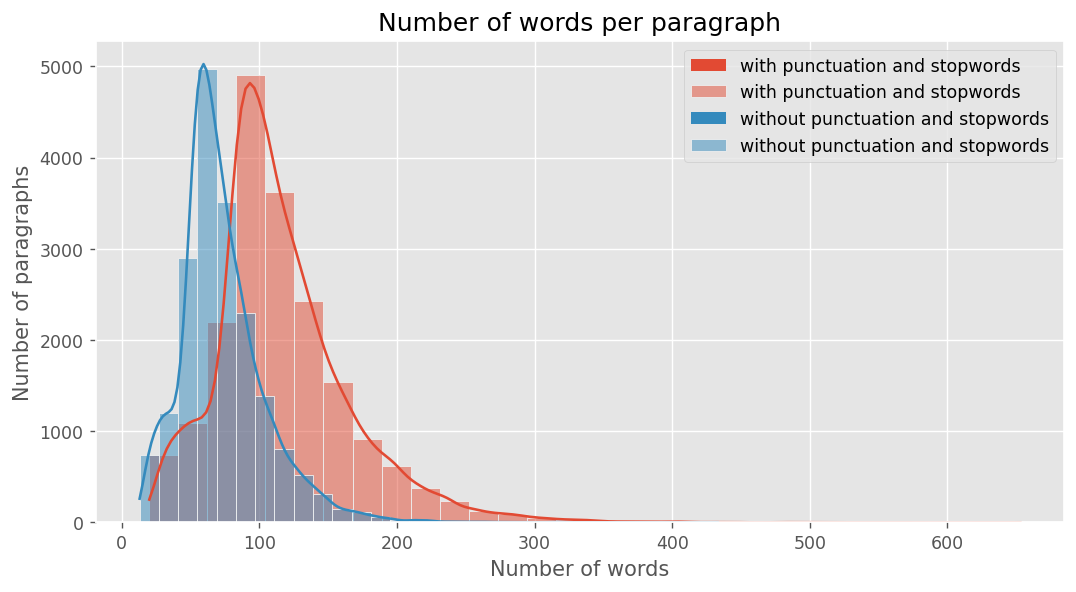

In [12]:
#number_of_words_per_paragraph = []
#number_of_words_per_paragraph_nopunctuation_nostopwords = []
#words_per_paragraph = []
#words_per_paragraph_nopunctuation_nostopwords = []
#for paragraphs in all_paragraphs_per_article:
#    for paragraph in paragraphs:
#        text = paragraph['context']
#        text_nopunctuation_nostopwords = re.sub(regex_punctuation,'',text).split()
#        text_nopunctuation_nostopwords = [w for w in text_nopunctuation_nostopwords if w not in stopwords.words('english')]
#        words_per_paragraph.append(text.split())
#        words_per_paragraph_nopunctuation_nostopwords.append(text_nopunctuation_nostopwords)
#        number_of_words_per_paragraph.append(len(words_per_paragraph[-1]))
#        number_of_words_per_paragraph_nopunctuation_nostopwords.append(len(words_per_paragraph_nopunctuation_nostopwords[-1]))

print("Maximum number of words per paragraph: ", max(number_of_words_per_paragraph))
print("Minimum number of words per paragraph: ", min(number_of_words_per_paragraph))
print("Average number of words per paragraph: ", sum(number_of_words_per_paragraph)/sum(number_of_paragraphs_per_article))
print("Maximum number of words per paragraph without punctuation and stopwords: ", max(number_of_words_per_paragraph_nopunctuation_nostopwords))
print("Minimum number of words per paragraph without punctuation and stopwords: ", min(number_of_words_per_paragraph_nopunctuation_nostopwords))
print("Average number of words per paragraph without punctuation and stopwords: ", sum(number_of_words_per_paragraph_nopunctuation_nostopwords)/sum(number_of_paragraphs_per_article))

num_bin = 15
intervallo_bin = (max(number_of_words_per_paragraph) - min(number_of_words_per_paragraph)) / num_bin
        
plt.figure(figsize=(10, 5), dpi=125)
sns.histplot(number_of_words_per_paragraph, bins=num_bin*2, kde=True, label='with punctuation and stopwords')
sns.histplot(number_of_words_per_paragraph_nopunctuation_nostopwords, bins=num_bin*2, kde=True, label='without punctuation and stopwords')
plt.xlabel('Number of words')
plt.ylabel('Number of paragraphs')
plt.title('Number of words per paragraph')
plt.legend(loc='upper right')
plt.show()


### Number of Words per Question

This code block does the following:

1. Calculates statistics on the number of words per question in the SQuAD 2.0 dataset, both with and without punctuation and stopwords. It finds the maximum, minimum, and average number of words per question for both scenarios.

2. Plots two overlaid histograms to show the distribution of the number of words per question, again for both scenarios. This provides a visualization of how many words are typically in a question in the dataset, both in their raw form and when preprocessed to remove punctuation and stopwords.

The primary goal of this analysis is to understand the complexity of the questions in the dataset. Questions with more words may be more complex and require more sophisticated understanding of language to answer correctly. The comparison between the scenarios with and without punctuation and stopwords helps to understand how much of the text in the questions is composed of punctuation and stopwords, which may not contribute significantly to the semantic meaning of the questions.

In [13]:
# Extract questions and count words
#word_counts = []
#word_counts_nopunctuation_nostopwords = []
#for topic in data_json["data"]:
#    for paragraph in topic["paragraphs"]:
#        for qas in paragraph["qas"]:
#            question = qas["question"]
#            question_nopunctuation_nostopwords = re.sub(regex_punctuation,'',question).split()
#            question_nopunctuation_nostopwords = [w for w in question_nopunctuation_nostopwords if w not in stopwords.words('english')]
#            word_count = len(question.split())
#            word_counts.append(word_count)
#            word_counts_nopunctuation_nostopwords.append(len(question_nopunctuation_nostopwords))

print("Maximum number of words per question: ", max(number_of_words_per_question))
print("Minimum number of words per question: ", min(number_of_words_per_question))
print("Average number of words per question: ", sum(number_of_words_per_question)/sum(number_of_questions_per_article))
print("Maximum number of words per question without punctuation and stopwords: ", max(number_of_words_per_question_nopunctuation_nostopwords))
print("Minimum number of words per question without punctuation and stopwords: ", min(number_of_words_per_question_nopunctuation_nostopwords))
print("Average number of words per question without punctuation and stopwords: ", sum(number_of_words_per_question_nopunctuation_nostopwords)/sum(number_of_questions_per_article))

num_bin = 10
intervallo_bin = (max(number_of_words_per_question) - min(number_of_words_per_question)) / num_bin
        
plt.figure(figsize=(10, 5), dpi=125)
sns.histplot(number_of_words_per_question, bins=num_bin*2, kde=False, label='with punctuation and stopwords')
sns.histplot(number_of_words_per_question_nopunctuation_nostopwords, bins=num_bin*2, kde=False, label='without punctuation and stopwords')
plt.xlabel('Number of words')
plt.ylabel('Number of questions')
plt.title('Number of words per question')
plt.legend(loc='upper right')
plt.show()


Maximum number of words per question:  40
Minimum number of words per question:  1
Average number of words per question:  9.893822082735442
Maximum number of words per question without punctuation and stopwords:  32
Minimum number of words per question without punctuation and stopwords:  0
Average number of words per question without punctuation and stopwords:  6.283734528349665


### Number of Words per Answer

In [14]:
# Extract answers and count words
#word_counts = []
#word_counts_nopunctuation_nostopwords = []
#for topic in data_json["data"]:
#    for paragraph in topic["paragraphs"]:
#        for qas in paragraph["qas"]:
#            for a in qas["answers"]:
#                answer = a["text"]
#                answer_nopunctuation_nostopwords = re.sub(regex_punctuation,'',answer).split()
#                answer_nopunctuation_nostopwords = [w for w in answer_nopunctuation_nostopwords if w not in stopwords.words('english')]
#                word_count = len(answer.split())
#                word_counts.append(word_count)
#                word_counts_nopunctuation_nostopwords.append(len(answer_nopunctuation_nostopwords))

print("Maximum number of words per answer: ", max(number_of_words_per_answer))
print("Minimum number of words per answer: ", min(number_of_words_per_answer))
print("Average number of words per answer: ", sum(number_of_words_per_answer)/sum(number_of_questions_per_article))
print("Maximum number of words per answer without punctuation and stopwords: ", max(number_of_words_per_answer_nopunctuation_nostopwords))
print("Minimum number of words per answer without punctuation and stopwords: ", min(number_of_words_per_answer_nopunctuation_nostopwords))
print("Average number of words per answer without punctuation and stopwords: ", sum(number_of_words_per_answer_nopunctuation_nostopwords)/sum(number_of_questions_per_article))

num_bin = 10
intervallo_bin = (max(number_of_words_per_answer) - min(number_of_words_per_answer)) / num_bin
        
plt.figure(figsize=(10, 5), dpi=125)
sns.histplot(number_of_words_per_answer, bins=num_bin*2, kde=True, label='with punctuation and stopwords')
sns.histplot(number_of_words_per_answer_nopunctuation_nostopwords, bins=num_bin*2, kde=True, label='without punctuation and stopwords')
plt.xlabel('Number of words')
plt.ylabel('Number of answers')
plt.title('Number of words per answer')
plt.legend(loc='upper right')
plt.show()


Maximum number of words per answer:  43
Minimum number of words per answer:  1
Average number of words per answer:  2.107098734643452
Maximum number of words per answer without punctuation and stopwords:  22
Minimum number of words per answer without punctuation and stopwords:  0
Average number of words per answer without punctuation and stopwords:  1.6359855431671513


# Vocabulary

Analyzing the vocabulary within the SQuAD 2.0 dataset is of paramount importance to question answering systems for several reasons. First, it provides insights into the lexical diversity and complexity of the dataset, helping us understand the range of language features that our models need to handle. Second, it can shed light on the types of entities, relations, and structures that are common in the questions and answers, which is crucial for tailoring our models to this specific task. Third, a vocabulary analysis can reveal potential biases in the dataset, such as over-representation of certain words or concepts, which could inadvertently influence our model's behavior. Lastly, understanding the dataset's vocabulary can guide us in choosing appropriate text representation methods, such as word embeddings or transformers, and in tuning these methods for optimal performance. Vocabulary analysis is thus a foundational step in building and improving question answering systems based on the SQuAD 2.0 dataset.

In [15]:
all_in_one_paragraphs = ''
all_in_one_questions = ''
all_in_one_answers = ''
for topic in data_json["data"]:
    for paragraph in topic["paragraphs"]:
        all_in_one_paragraphs += " " + paragraph["context"]
        for qas in paragraph["qas"]:
            all_in_one_questions += " " + qas["question"]
            for a in qas["answers"]:
                all_in_one_answers += " " + a["text"]

words_paragraphs = all_in_one_paragraphs.lower()
words_questions = all_in_one_questions.lower()
words_answers = all_in_one_answers.lower()

words_paragraphs_nopunctuation = re.sub(regex_punctuation,'',words_paragraphs).split()
words_paragraphs_nopunctuation_nostopwords = [w for w in words_paragraphs_nopunctuation if w not in stopwords.words('english')]
words_questions_nopunctuation = re.sub(regex_punctuation,'',words_questions).split()
words_questions_nopunctuation_nostopwords = [w for w in words_questions_nopunctuation if w not in stopwords.words('english')]
words_answers_nopunctuation = re.sub(regex_punctuation,'',words_answers).split()
words_answers_nopunctuation_nostopwords = [w for w in words_answers_nopunctuation if w not in stopwords.words('english')]

print("Number of words in vocabolary of paragraphs after removing punctuation and stopwords:", len(set(words_paragraphs_nopunctuation_nostopwords)))
print("Number of words in vocabolary of questions after removing punctuation and stopwords:", len(set(words_questions_nopunctuation_nostopwords)))
print("Number of words in vocabolary of answers after removing punctuation and stopwords:", len(set(words_answers_nopunctuation_nostopwords)))


Number of words in vocabolary of paragraphs after removing punctuation and stopwords: 98445
Number of words in vocabolary of questions after removing punctuation and stopwords: 47385
Number of words in vocabolary of answers after removing punctuation and stopwords: 42142


## The Most Common 100 Words

In [16]:
p = nltk.Counter(words_paragraphs_nopunctuation_nostopwords)
print("The most common 100 words in the vocabolary of paragraphs: \n", p.most_common(100))
q = nltk.Counter(words_questions_nopunctuation_nostopwords)
print("The most common 100 words in the vocabolary of questions: \n", q.most_common(100))
a = nltk.Counter(words_answers_nopunctuation_nostopwords)
print("The most common 100 words in the vocabolary of answers: \n", a.most_common(100))

The most common 100 words in the vocabolary of paragraphs: 
 [('also', 5846), ('one', 4386), ('first', 4237), ('new', 4144), ('city', 3684), ('many', 3331), ('two', 2951), ('states', 2945), ('used', 2926), ('may', 2801), ('time', 2669), ('state', 2591), ('world', 2530), ('united', 2478), ('century', 2462), ('would', 2377), ('war', 2375), ('years', 2122), ('known', 2098), ('including', 2091), ('however', 2060), ('government', 1984), ('use', 1977), ('people', 1936), ('early', 1885), ('became', 1873), ('system', 1840), ('since', 1819), ('us', 1809), ('later', 1772), ('made', 1739), ('well', 1726), ('number', 1708), ('part', 1688), ('population', 1672), ('called', 1663), ('national', 1649), ('north', 1633), ('often', 1631), ('several', 1541), ('major', 1533), ('three', 1528), ('power', 1520), ('million', 1499), ('university', 1499), ('although', 1465), ('south', 1443), ('british', 1439), ('american', 1438), ('year', 1434), ('area', 1419), ('music', 1392), ('period', 1385), ('large', 1337),

## Number of Words per Frequency in Paragraphs

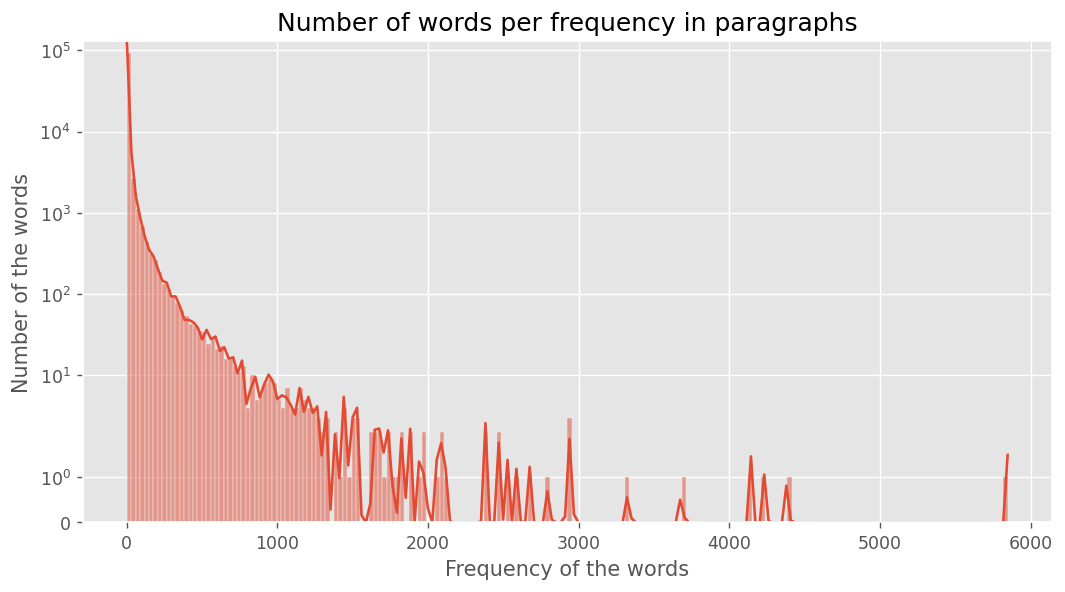

In [17]:
values = list(p.values())
# Plot histogram
num_bin = 100
intervallo_bin = (max(values) - min(values)) / num_bin

plt.figure(figsize=(10, 5), dpi=125)
sns.histplot(values, bins=num_bin*2, kde=True)
plt.xlabel('Frequency of the words')
plt.ylabel('Number of the words')
plt.title('Number of words per frequency in paragraphs')
plt.yscale('symlog')
plt.show()

In [18]:
values = list(p.values())
values = np.array(values)
max(values[0:2])

180

## Number of Words per Frequency in Answers

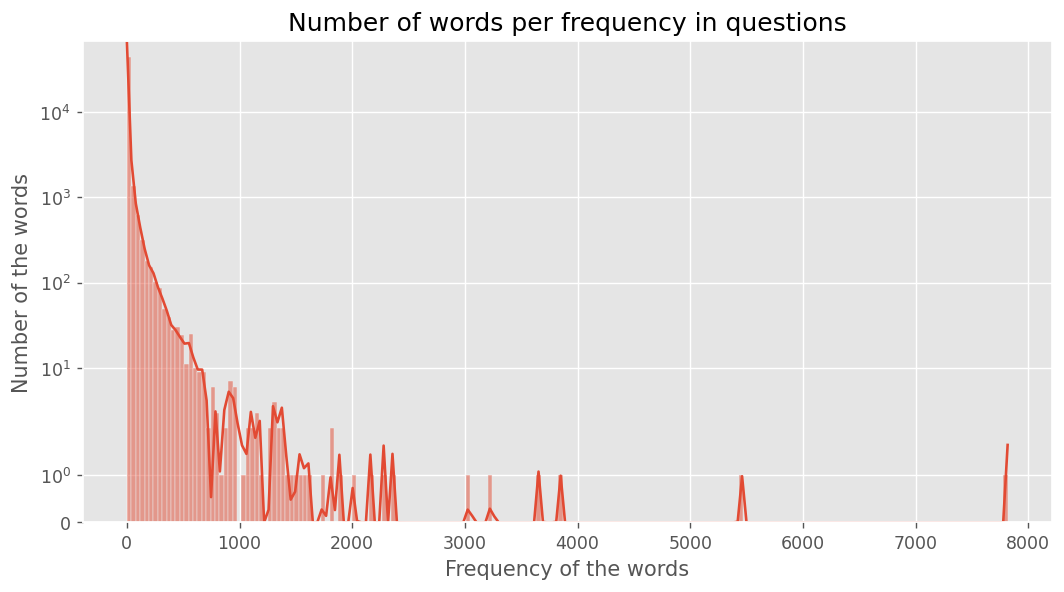

In [19]:
values = list(q.values())
# Plot histogram
num_bin = 100
intervallo_bin = (max(values) - min(values)) / num_bin

plt.figure(figsize=(10, 5), dpi=125)
sns.histplot(values, bins=num_bin*2, kde=True)
plt.xlabel('Frequency of the words')
plt.ylabel('Number of the words')
plt.title('Number of words per frequency in answers')
plt.yscale('symlog')
plt.show()

## Number of Words per Frequency in Questions

In [20]:
values = list(a.values())
# Plot histogram
num_bin = 100
intervallo_bin = (max(values) - min(values)) / num_bin

plt.figure(figsize=(10, 5), dpi=125)
sns.histplot(values, bins=num_bin*2, kde=True)
plt.xlabel('Frequency of the words')
plt.ylabel('Number of the words')
plt.title('Number of words per frequency in questions')
plt.yscale('symlog')
plt.show()

## Word Cloud

The word cloud visualization is a helpful tool when you want to understand the most prominent words in a text corpus, in this case, the paragraphs of the SQuAD dataset. Each word's size in the word cloud indicates its frequency or importance in the text. This visual representation can give a quick intuitive sense of the content without having to read through all the text or review frequency counts.

### Word Cloud for Words in the Paragraphs

In [21]:
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_in_one_paragraphs)

# Plot the word cloud
plt.figure(figsize=(10, 5), dpi=125)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Word Cloud for words in the paragraphs')
plt.show()


### Word Cloud for Words in the Paragraphs after removing Punctuation and Stopwords

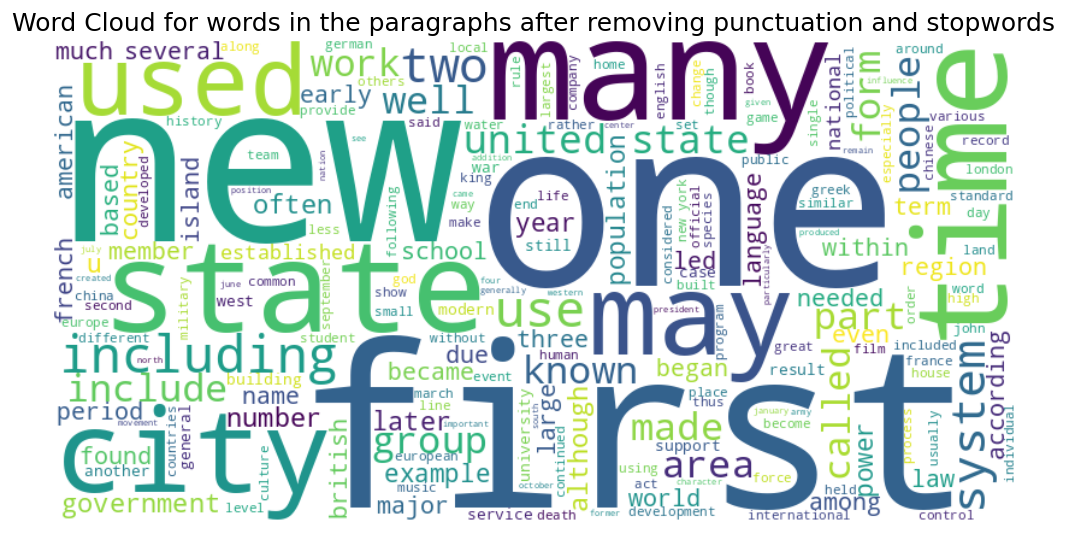

In [22]:
# Join the words in the list to create a single string
text = " ".join(words_paragraphs_nopunctuation_nostopwords)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5), dpi=125)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Word Cloud for words in the paragraphs after removing punctuation and stopwords')
plt.show()


### Word Cloud for Words in the Questions

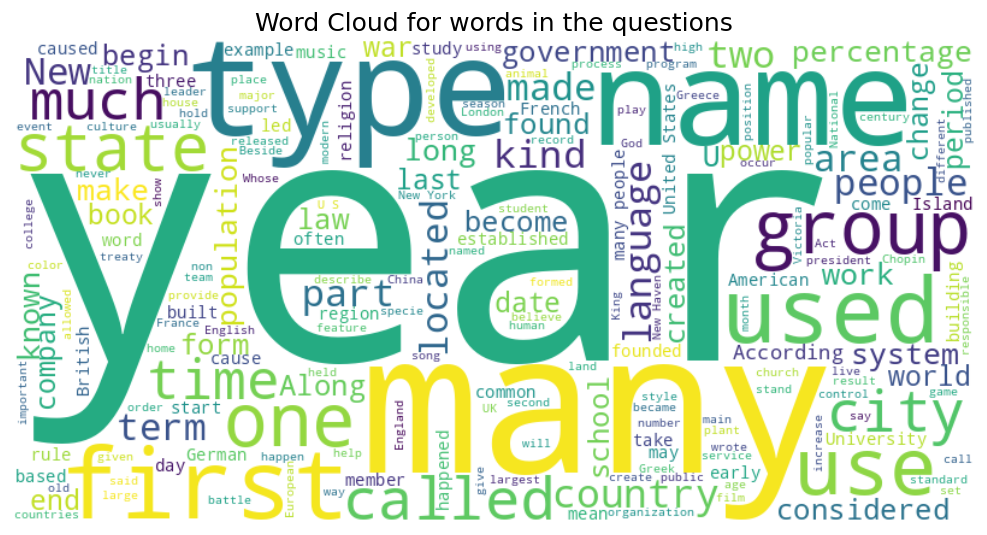

In [23]:
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_in_one_questions)

# Plot the word cloud
plt.figure(figsize=(10, 5), dpi=125)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Word Cloud for words in the questions')
plt.show()


### Word Cloud for Words in the Questions after removing Punctuation and Stopwords

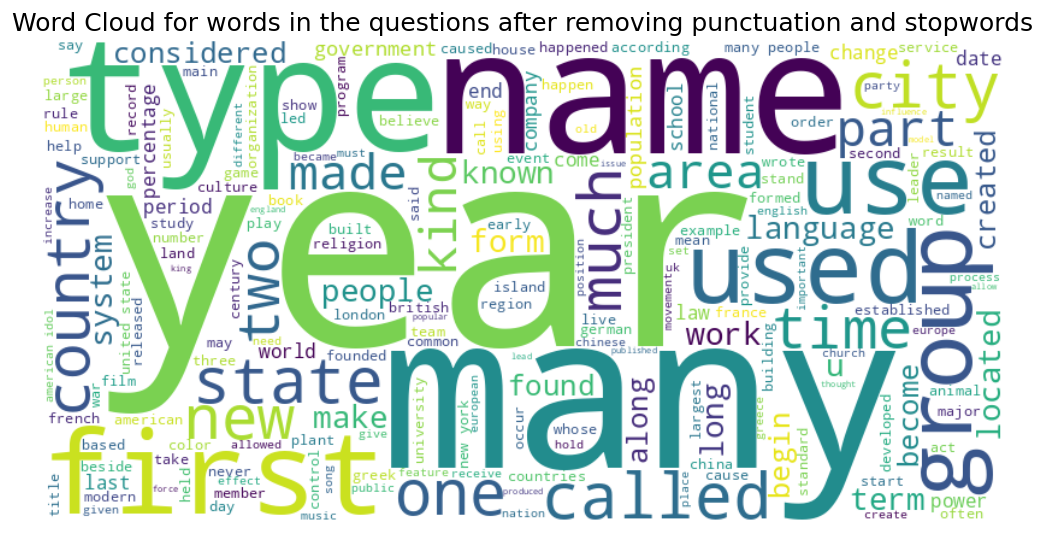

In [24]:
# Join the words in the list to create a single string
text = " ".join(words_questions_nopunctuation_nostopwords)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5), dpi=125)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Word Cloud for words in the questions after removing punctuation and stopwords')
plt.show()


### Word Cloud for Words in the all Answers combined

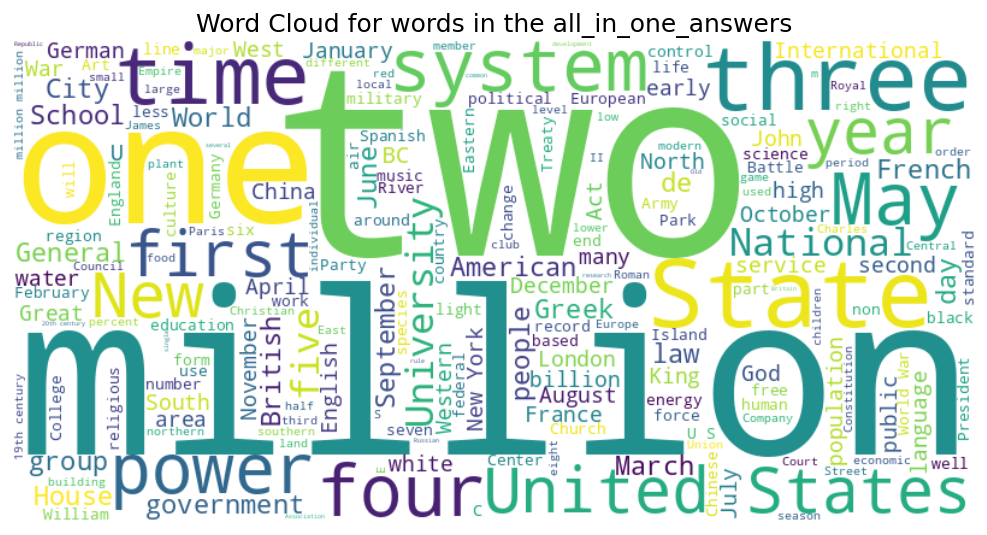

In [25]:
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_in_one_answers)

# Plot the word cloud
plt.figure(figsize=(10, 5), dpi=125)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Word Cloud for words in the all_in_one_answers')
plt.show()


### Word Cloud for Words in the answers after removing Punctuation and Stopwords

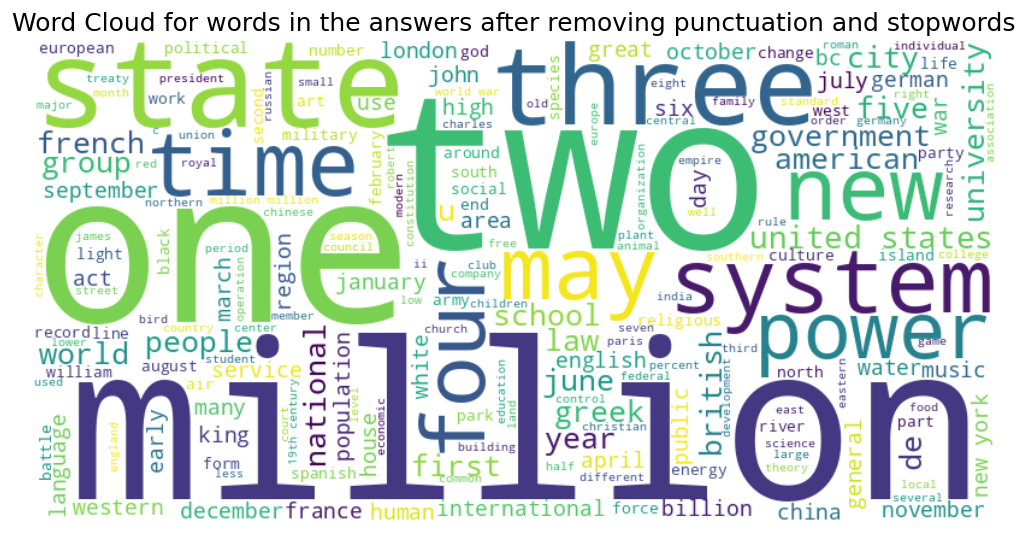

In [26]:
# Join the words in the list to create a single string
text = " ".join(words_answers_nopunctuation_nostopwords)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5), dpi=125)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Word Cloud for words in the answers after removing punctuation and stopwords')
plt.show()


## Frequency Distribution

Frequency distribution of the top N most common words in the dataset. This can help to understand the distribution of words and identify the most frequent words in the dataset.

### Frequency Distribution of Top 20 Words in the Vocabulary

[('also', 5846), ('one', 4386), ('first', 4237), ('new', 4144), ('city', 3684), ('many', 3331), ('two', 2951), ('states', 2945), ('used', 2926), ('may', 2801), ('time', 2669), ('state', 2591), ('world', 2530), ('united', 2478), ('century', 2462), ('would', 2377), ('war', 2375), ('years', 2122), ('known', 2098), ('including', 2091)]


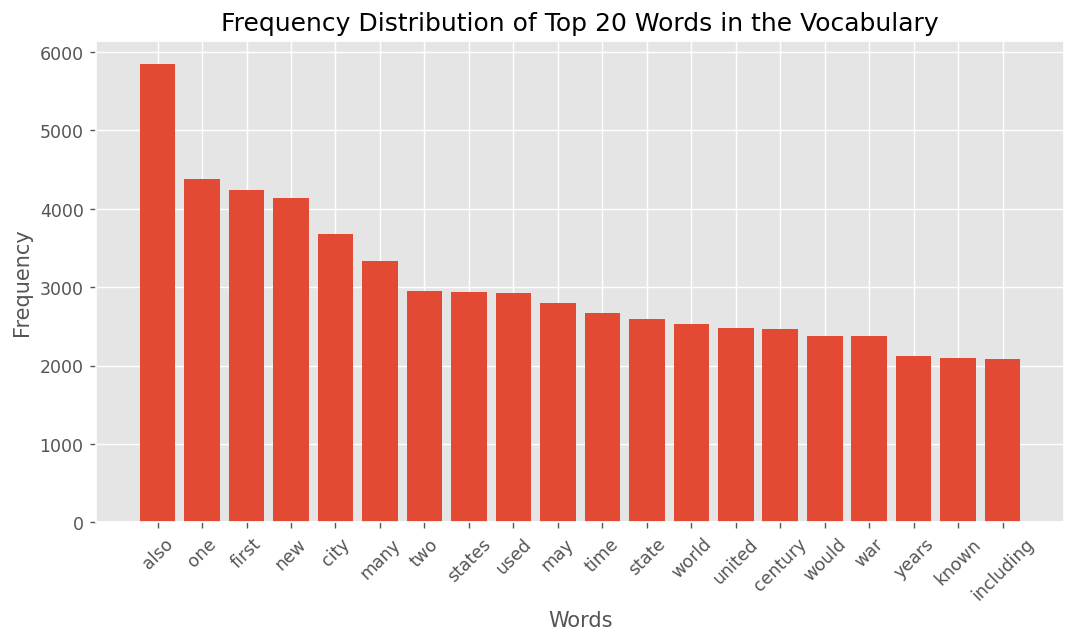

In [27]:
# Count the occurrences of each word
word_counter = collections.Counter(words_paragraphs_nopunctuation_nostopwords) # With lower, removing stopwords and punctuation

# Get the top N most common words
N = 20

most_common_words = word_counter.most_common(N)
print(most_common_words)

# Separate words and counts for plotting
words, counts = zip(*most_common_words)

# Plot the frequency distribution
plt.figure(figsize=(10, 5), dpi=125)
plt.bar(words, counts)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Frequency Distribution of Top {} Words in the Vocabulary".format(N))
plt.xticks(rotation=45)
plt.show()


### Cumulative Distribution

Cumulative distribution function (CDF) shows the proportion of the dataset vocabulary covered by the top N most frequent words. This can help to understand the overall vocabulary richness and identify any Zipf's law patterns in the dataset.

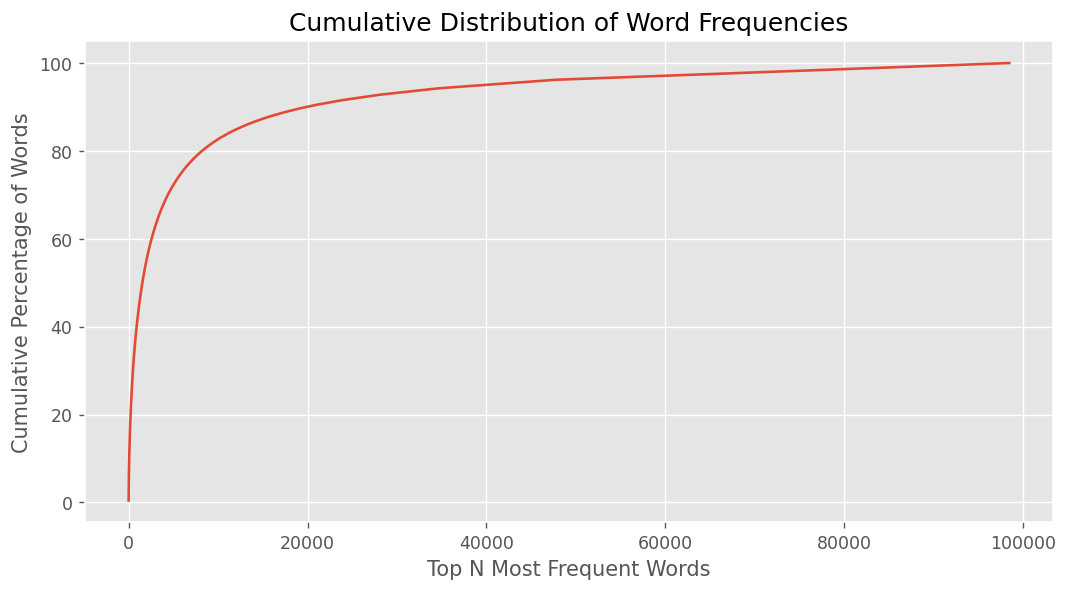

In [28]:
# Count the occurrences of each word
word_counter = collections.Counter(words_paragraphs_nopunctuation_nostopwords)

# Sort words by frequency in descending order
sorted_word_counts = sorted(word_counter.values(), reverse=True)

# Calculate cumulative sum
cumulative_word_counts = np.cumsum(sorted_word_counts)

# Calculate cumulative percentage
total_word_count = sum(word_counter.values())
cumulative_percentage = cumulative_word_counts / total_word_count * 100

# Plot the cumulative distribution
plt.figure(figsize=(10, 5), dpi=125)
plt.plot(cumulative_percentage)
plt.xlabel("Top N Most Frequent Words")
plt.ylabel("Cumulative Percentage of Words")
plt.title("Cumulative Distribution of Word Frequencies")
plt.show()


### N-Gram

Instead of analyzing individual words, visualize the most common n-grams (groups of n words) in the dataset. This can help to identify common phrases or patterns in the dataset. 

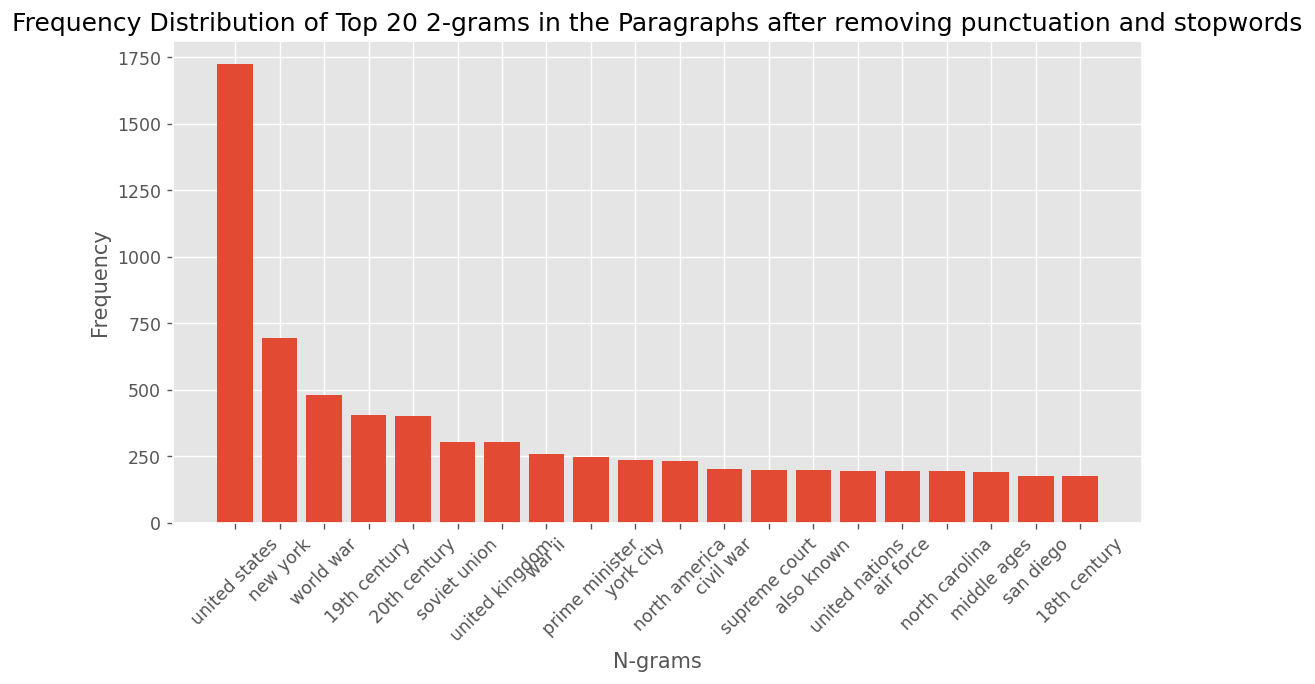

In [29]:
# Define the n-gram size (e.g., 2 for bigrams, 3 for trigrams, etc.)
n = 2

# Generate n-grams from the list of words
ngram_list = list(ngrams(words_paragraphs_nopunctuation_nostopwords, n))

# Count the occurrences of each n-gram
ngram_counter = FreqDist(ngram_list)

# Get the top N most common n-grams
N = 20
most_common_ngrams = ngram_counter.most_common(N)

# Separate n-grams and counts for plotting
ngram_tuples, counts = zip(*most_common_ngrams)  # Change the variable name here

# Convert n-gram tuples to strings for plotting
ngram_strings = [" ".join(ngram) for ngram in ngram_tuples]

# Plot the n-gram frequency distribution
plt.figure(figsize=(10, 5), dpi=125)
plt.bar(ngram_strings, counts)
plt.xlabel("N-grams")
plt.ylabel("Frequency")
plt.title("Frequency Distribution of Top {} {}-grams in the Paragraphs after removing punctuation and stopwords".format(N, n))
plt.xticks(rotation=45)
plt.show()


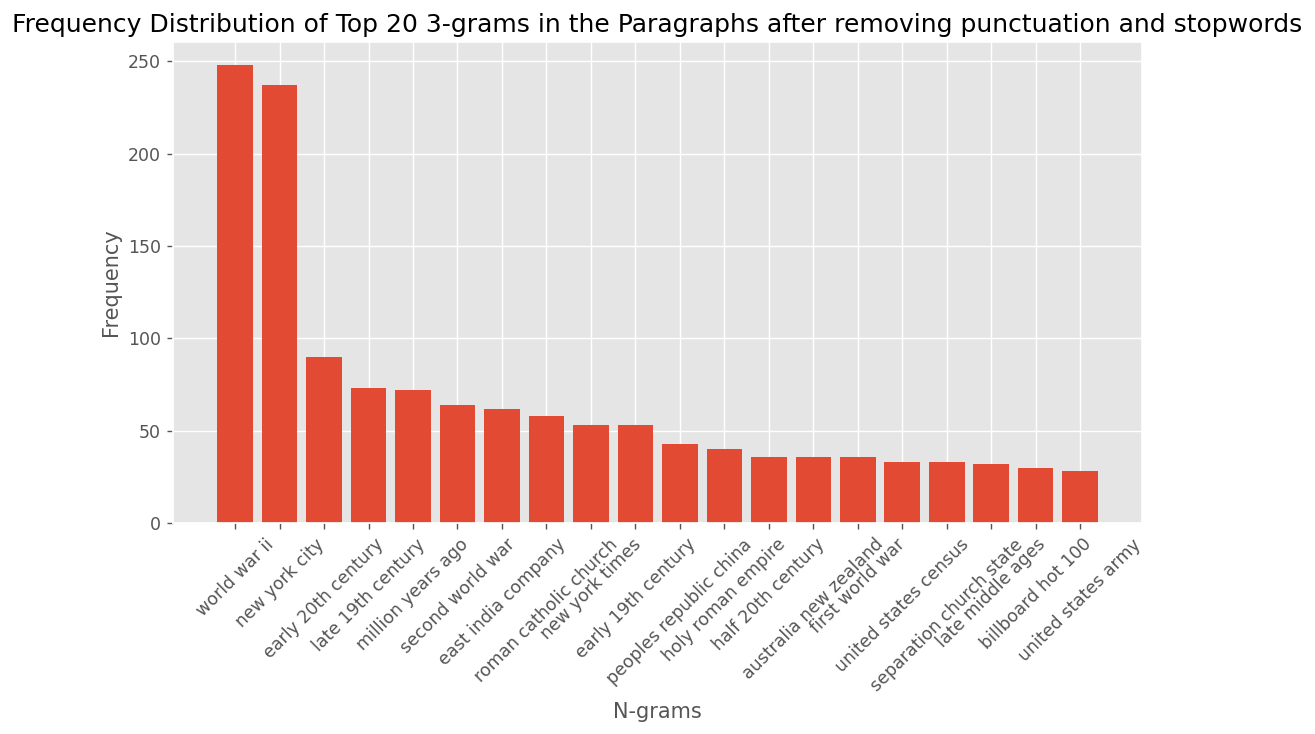

In [30]:
# Define the n-gram size (e.g., 2 for bigrams, 3 for trigrams, etc.)
n = 3

# Generate n-grams from the list of words
ngram_list = list(ngrams(words_paragraphs_nopunctuation_nostopwords, n))

# Count the occurrences of each n-gram
ngram_counter = FreqDist(ngram_list)

# Get the top N most common n-grams
N = 20
most_common_ngrams = ngram_counter.most_common(N)

# Separate n-grams and counts for plotting
ngram_tuples, counts = zip(*most_common_ngrams)  # Change the variable name here

# Convert n-gram tuples to strings for plotting
ngram_strings = [" ".join(ngram) for ngram in ngram_tuples]

# Plot the n-gram frequency distribution
plt.figure(figsize=(10, 5), dpi=125)
plt.bar(ngram_strings, counts)
plt.xlabel("N-grams")
plt.ylabel("Frequency")
plt.title("Frequency Distribution of Top {} {}-grams in the Paragraphs after removing punctuation and stopwords".format(N, n))
plt.xticks(rotation=45)
plt.show()


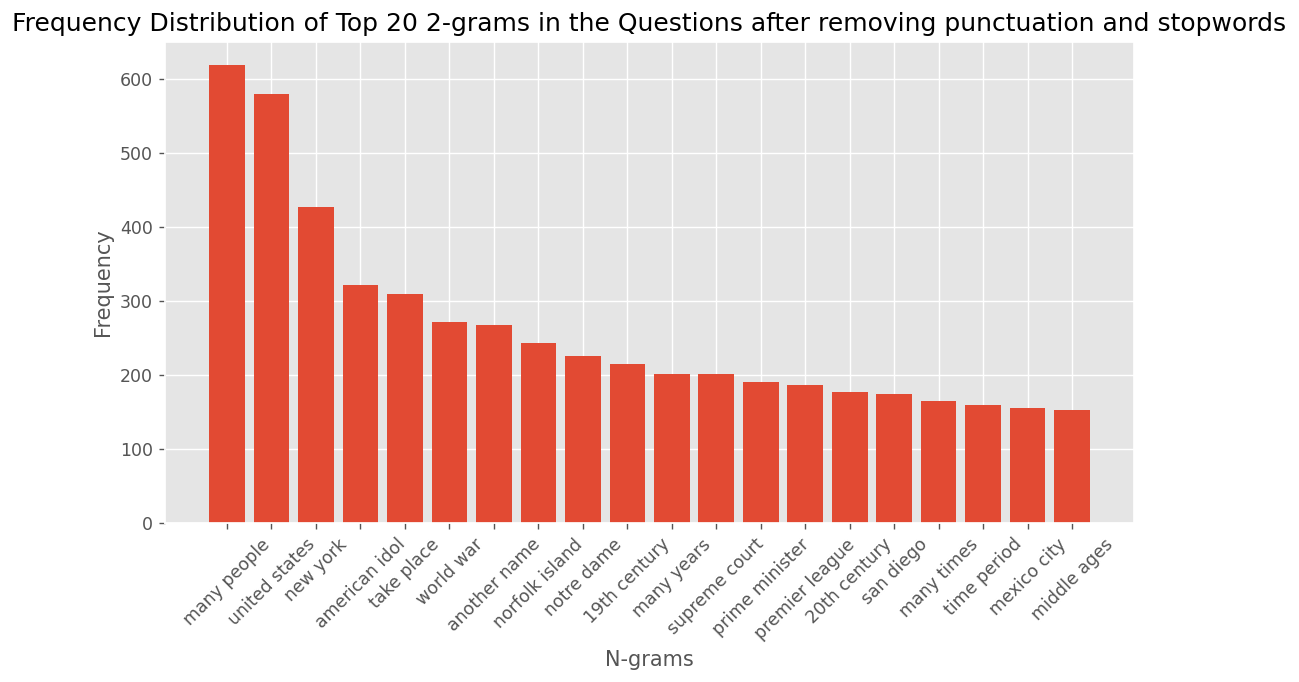

In [31]:
# Define the n-gram size (e.g., 2 for bigrams, 3 for trigrams, etc.)
n = 2

# Generate n-grams from the list of words
ngram_list = list(ngrams(words_questions_nopunctuation_nostopwords, n))

# Count the occurrences of each n-gram
ngram_counter = FreqDist(ngram_list)

# Get the top N most common n-grams
N = 20
most_common_ngrams = ngram_counter.most_common(N)

# Separate n-grams and counts for plotting
ngram_tuples, counts = zip(*most_common_ngrams)  # Change the variable name here

# Convert n-gram tuples to strings for plotting
ngram_strings = [" ".join(ngram) for ngram in ngram_tuples]

# Plot the n-gram frequency distribution
plt.figure(figsize=(10, 5), dpi=125)
plt.bar(ngram_strings, counts)
plt.xlabel("N-grams")
plt.ylabel("Frequency")
plt.title("Frequency Distribution of Top {} {}-grams in the Questions after removing punctuation and stopwords".format(N, n))
plt.xticks(rotation=45)
plt.show()


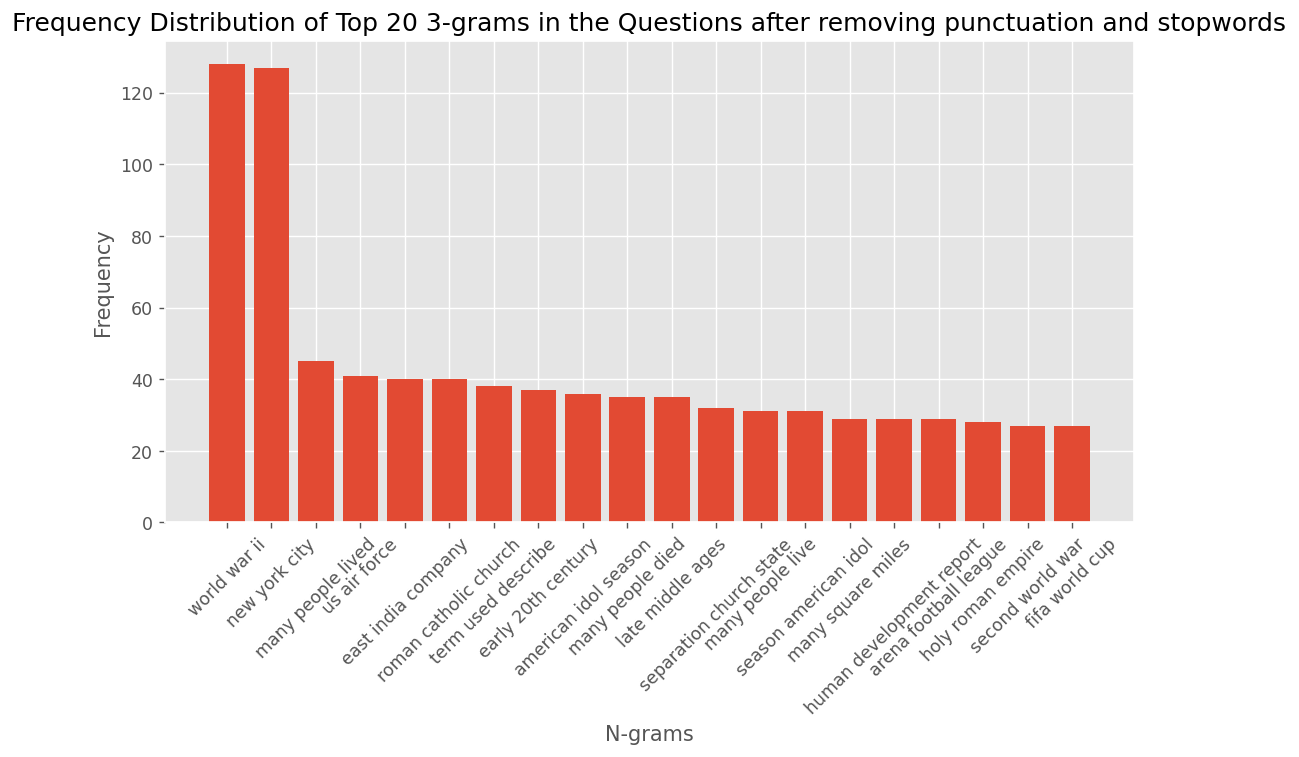

In [32]:
# Define the n-gram size (e.g., 2 for bigrams, 3 for trigrams, etc.)
n = 3

# Generate n-grams from the list of words
ngram_list = list(ngrams(words_questions_nopunctuation_nostopwords, n))

# Count the occurrences of each n-gram
ngram_counter = FreqDist(ngram_list)

# Get the top N most common n-grams
N = 20
most_common_ngrams = ngram_counter.most_common(N)

# Separate n-grams and counts for plotting
ngram_tuples, counts = zip(*most_common_ngrams)  # Change the variable name here

# Convert n-gram tuples to strings for plotting
ngram_strings = [" ".join(ngram) for ngram in ngram_tuples]

# Plot the n-gram frequency distribution
plt.figure(figsize=(10, 5), dpi=125)
plt.bar(ngram_strings, counts)
plt.xlabel("N-grams")
plt.ylabel("Frequency")
plt.title("Frequency Distribution of Top {} {}-grams in the Questions after removing punctuation and stopwords".format(N, n))
plt.xticks(rotation=45)
plt.show()


## TF-IDF

Term Frequency-Inverse Document Frequency (TF-IDF) is a crucial statistical measure that reflects how important a word is to a document within a corpus. Analyzing TF-IDF can be critical for several reasons.

First, it aids in understanding the significance of words in the context of the dataset. Words with high TF-IDF scores are often those that provide the most meaningful information in a document, as they appear frequently in the document but infrequently in the rest of the corpus. Hence, examining the TF-IDF can highlight key words or concepts that are particularly relevant to certain documents in the corpus.

Second, TF-IDF can help identify words that are less useful for machine learning models. If a word has a low TF-IDF score, this suggests it appears frequently across many documents, and is therefore less informative about individual documents. These words, often common words or stop words, may contribute to noise in the dataset and can be less useful for models.

Lastly, understanding TF-IDF scores can guide feature selection and preprocessing steps. For instance, if you're building a model to predict some outcome based on the text, words with high TF-IDF scores may be useful features. On the other hand, words with very low or very high scores might be removed during preprocessing to reduce noise and computational complexity.

In the context of a task like question answering on SQuAD 2.0, TF-IDF can be used to understand which words or phrases are particularly important within specific contexts, aiding in understanding the data and potentially improving model performance.

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

with open("/work/train-v2.0.json", "r") as file:
    data = json.load(file)

# Extract the paragraphs from the JSON data
documents = []
for article in data["data"]:
    for paragraph in article["paragraphs"]:
        documents.append(paragraph["context"])

# Define the number of top words to display in the heatmap
N = 10

# Calculate TF-IDF scores for the documents
vectorizer = TfidfVectorizer(stop_words='english', max_features=N)
tfidf_matrix = vectorizer.fit_transform(documents)

# Create a DataFrame with the TF-IDF scores
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names())

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Plotting the top 10 most frequently used words in a TF-IDF heatmap can provide several useful insights for natural language processing tasks.

Identifying Important Words: The top 10 words with the highest TF-IDF scores are those that appear frequently in some documents but infrequently in the corpus as a whole. These words are likely to be particularly important or informative about the content of those documents. By plotting these words in a heatmap, you can easily see which words carry significant weight in your dataset.

Visualizing Document Similarity: A TF-IDF heatmap effectively illustrates the distribution of important words across different documents. If two documents have similar colors in the heatmap for the same word, that suggests they have similar content regarding that term. This could be useful for tasks like document clustering or topic modeling.

Interpreting Model Features: If you're using a bag-of-words or TF-IDF representation as input to a machine learning model, the top 10 words are likely to be important features that the model uses to make predictions. A heatmap can give you a sense of which features your model is paying most attention to, which can be useful for model interpretation and debugging.

Informing Data Preprocessing: If the top 10 words are all common, uninformative words (like "the", "and", "is", etc.), this could suggest that you need to do more data preprocessing, such as stopword removal, to ensure your TF-IDF scores are actually capturing meaningful content.

In summary, a TF-IDF heatmap is a powerful tool for understanding your data and the behavior of your models.

In [34]:
# Plot the heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(tfidf_df, cmap="viridis", annot=False, cbar=True, xticklabels=True, yticklabels=False)
plt.xlabel("Top {} Words".format(N))
plt.ylabel("Documents")
plt.title("TF-IDF Heatmap for the Top {} Most Frequent Words in Documents".format(N))
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=43adf7e0-69c2-458a-bdc9-81a8ce3733f2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>